<a href="https://colab.research.google.com/github/paolo-peretti/conv/blob/main/conv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
%matplotlib inline

In [58]:
import torch
torch.cuda.empty_cache()
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Preproccessing on dataset

In [59]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(*stats,inplace=True)])


# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)



batch_size = 8


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


# Class labels
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


I want see a grid of images of the dataset

horse
.............................................



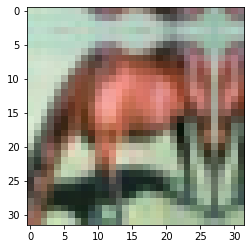

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def imshow(img):
    img = img.cpu()
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(training_loader)
images, labels = dataiter.next()
# print(len(images), len(labels))
print(classes[labels[0]])
print('.............................................\n')
imshow(images[0])




Building The Model
============================

One important behavior of ``torch.nn.Module`` is registering parameters.
If a particular ``Module`` subclass has learning weights, these weights
are expressed as instances of ``torch.nn.Parameter``. The ``Parameter``
class is a subclass of ``torch.Tensor``, with the special behavior that
when they are assigned as attributes of a ``Module``, they are added to
the list of that modules parameters. These parameters may be accessed
through the ``parameters()`` method on the ``Module`` class.

As a simple example, here’s a very simple model with two linear layers
and an activation function. We’ll create an instance of it and ask it to
report on its parameters:


In [61]:


class MyModel(torch.nn.Module):
    
    def __init__(self):
        super(MyModel, self).__init__()
        
        # CV
        self.conv1 = torch.nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5, padding=2,stride=1)
        self.bn1 = torch.nn.BatchNorm2d(6)
        
        self.conv2 = torch.nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3, padding=1,stride=1)
        self.bn2 = torch.nn.BatchNorm2d(16)

        self.conv3 = torch.nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3, padding=1,stride=1)
        self.bn3 = torch.nn.BatchNorm2d(32)

        self.conv4 = torch.nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2, padding=1,stride=1)
        self.bn4 = torch.nn.BatchNorm2d(64)

        self.pool = torch.nn.MaxPool2d(2, 2)


        # FC
        self.linear1 = torch.nn.Linear(64*16*16, 540)
        self.linear2 = torch.nn.Linear(540, 146)
        self.linear3 = torch.nn.Linear(146, 10)

        # Define proportion or neurons to dropout
        self.dropout = torch.nn.Dropout(0.25)


        # self.softmax = torch.nn.Softmax(dim=10)
    
    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        # print(x.shape)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        # print(x.shape)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.pool(x)

        # print(x.shape)
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = x.view(-1, 64*16*16)
        # print(x.shape)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.dropout(x)

        output = F.log_softmax(x, dim=1)
        return output

my_model = MyModel()
my_model = my_model.to(device)

print('The model:')
print(my_model)



The model:
MyModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=16384, out_features=540, bias=True)
  (linear2): Linear(in_features=540, out_features=146, bias=True)
  (linear3): Linear(in_features=146, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace


Loss Function

In [62]:
def conv_block(in_channels, out_channels, pool=False):

    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # Conv. Layers
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.conv3 = conv_block(128, 128)
        self.conv4 = conv_block(128, 256, pool=True)
        self.conv5 = conv_block(256, 512, pool=True)
        self.conv6 = conv_block(512, 512)

        self.dropout = nn.Dropout(0.25)
        
        # FN
        self.fn1 = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, 256))
        
        self.fn2 = nn.Linear(256, num_classes)
        
        self.classifier = nn.LogSoftmax(dim=1)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)

        out = self.fn1(out)
        out = self.dropout(out)
        out = self.fn2(out)
        
        out = self.classifier(out)
        return out

resnet = ResNet9(3,10)
resnet = resnet.to(device)
print(resnet)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_si

In [63]:
model = resnet

In [64]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

The Training Loop

In [65]:
def accuracy(outputs, labels):

    _, preds = torch.max(outputs, dim=1)

    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [66]:
@torch.no_grad()
def evaluate(model, validation_loader):

    with torch.no_grad():
      
      model.eval()

      running_vloss = 0.0
      running_vacc = 0.0

      for i, vdata in enumerate(validation_loader):

          vinputs, vlabels = vdata

          vinputs = vinputs.to(device)
          vlabels = vlabels.to(device)
          
          voutputs = model(vinputs)
          

          running_vloss += loss_fn(voutputs, vlabels).item()
        
          running_vacc += accuracy(voutputs, vlabels).item()

      avg_vloss = running_vloss / (i + 1)
      avg_vaccuracy = running_vacc / (i + 1)

      print('  avg_vloss: {}'.format(avg_vloss))
      print('  avg_vaccuracy: {}'.format(avg_vaccuracy))

      return avg_vloss, avg_vaccuracy

In [67]:
def train_one_epoch(epoch_index):

    model.train()
  
    running_loss = 0.
    running_accuracy = 0.

 
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        

        running_accuracy += accuracy(outputs,labels).item()


        if i % 1000 == 999:

            last_loss = running_loss / 1000
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            last_accuracy = running_accuracy / 1000
            print('  batch {} accuracy: {}'.format(i + 1, last_accuracy))
            
            running_loss = 0.
            running_accuracy = 0.

            print('-----------------------------------------------------------------------')
  

      
    # last_loss = running_loss / (i + 1) # loss per batch
    # last_accuracy = running_accuracy / (i + 1)
    # print('  loss: {}'.format(last_loss))
    # print('  accuracy: {}'.format(last_accuracy))
    
      

    return last_loss, last_accuracy

In [68]:
def train_data(EPOCHS):

  patience = 2
  best_vloss = 1_000_000.
  trigger_times = 0

  for epoch in range(EPOCHS):

      print('\n\nEPOCH {}:'.format(epoch + 1))

      model.requires_grad_(True)
      
      avg_loss, avg_accuracy = train_one_epoch(epoch)

      model.requires_grad_(False)

      vloss, vaccuracy = evaluate(model, validation_loader)
      

      # Early stopping
        
      if avg_loss > best_vloss:
          trigger_times += 1
          print('Trigger Times:', trigger_times)

          if trigger_times >= patience:
              print('Early stopping!\nStart to test process.')
              return model

          else:
              print('trigger times: 0')
              trigger_times = 0

      best_vloss = avg_loss

  return model

In [69]:


model = train_data(10)

torch.save(model.state_dict(), 'cifar10_model.pth')




EPOCH 1:
  batch 1000 loss: 2.0624893379211424
  batch 1000 accuracy: 0.238125
-----------------------------------------------------------------------
  batch 2000 loss: 1.7837999408245087
  batch 2000 accuracy: 0.33175
-----------------------------------------------------------------------
  batch 3000 loss: 1.6442340562939644
  batch 3000 accuracy: 0.400375
-----------------------------------------------------------------------
  batch 4000 loss: 1.4923721429407597
  batch 4000 accuracy: 0.461
-----------------------------------------------------------------------
  batch 5000 loss: 1.3917295094132422
  batch 5000 accuracy: 0.495875
-----------------------------------------------------------------------
  batch 6000 loss: 1.289499269962311
  batch 6000 accuracy: 0.54925
-----------------------------------------------------------------------
  avg_vloss: 1.1002121130108833
  avg_vaccuracy: 0.6051


EPOCH 2:
  batch 1000 loss: 1.176365318313241
  batch 1000 accuracy: 0.584125
-------

In [70]:
# dataiter = iter(validation_loader)
# images, labels = dataiter.next()

# # print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# images=images.to(device)
# outputs = model(images)
# _, predicted = torch.max(outputs, 1)
# print('predicted : ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

import random


index = random.randint(0, 2500 - 1)


for i, data in enumerate(validation_loader):
        # Every data instance is an input + label pair
        if index==i:
          inputs, labels = data
          
          inputs = inputs.to(device)
          labels = labels.to(device)

          # Make predictions for this batch
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          imshow(inputs[0])
          print('labels: ',classes[labels[0]])
          print('predicted: ',classes[predicted[0]])
          break

In [71]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
pred=0
total=0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        labels = labels.to(device)
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        pred += (predicted == labels).sum().item()
        total += labels.size(0)

        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * pred / total))

print('--------------------------------------------------------------\n')

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    


Accuracy of the network on the 10000 test images: 82 %
--------------------------------------------------------------

Accuracy of airplane : 88 %
Accuracy of automobile : 95 %
Accuracy of  bird : 71 %
Accuracy of   cat : 68 %
Accuracy of  deer : 78 %
Accuracy of   dog : 79 %
Accuracy of  frog : 89 %
Accuracy of horse : 85 %
Accuracy of  ship : 82 %
Accuracy of truck : 81 %
